In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-07-17 19:27:54--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-07-17 19:27:54 (2.95 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



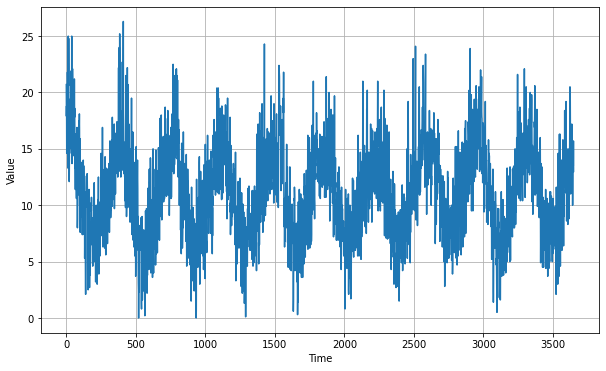

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  csvreader = csv.reader(csvfile, delimiter=',')
  next(csvreader)
  cnt = 0
  for row in csvreader:
    temps.append(float(row[1]))
    time_step.append(cnt)
    cnt += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # This type of division affects accuracy a LOT!
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    result = model.predict(ds)
    return result

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', 
                         activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*25)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule], verbose=1)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/150
10/10 [==============================] - 0s 20ms/step - loss: 5.8918 - mae: 6.3789 - lr: 1.0000e-08
Epoch 2/150
10/10 [==============================] - 0s 27ms/step - loss: 5.8860 - mae: 6.3729 - lr: 1.1220e-08
Epoch 3/150
10/10 [==============================] - 0s 26ms/step - loss: 5.8798 - mae: 6.3667 - lr: 1.2589e-08
Epoch 4/150
10/10 [==============================] - 0s 26ms/step - loss: 5.8604 - mae: 6.3474 - lr: 1.4125e-08
Epoch 5/150
10/10 [==============================] - 0s 26ms/step - loss: 5.8567 - mae: 6.3437 - lr: 1.5849e-08
Epoch 6/150
10/10 [==============================] - 0s 27ms/step - loss: 5.8505 - mae: 6.3372 - lr: 1.7783e-08
Epoch 7/150
10/10 [==============================] - 0s 25ms/step - loss: 5.8321 - mae: 6.3187 - lr: 1.9953e-08
Epoch 8/150
10/10 [==============================] - 0s 26ms/step - loss: 5.8141 - mae: 6.3006 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 60.0)

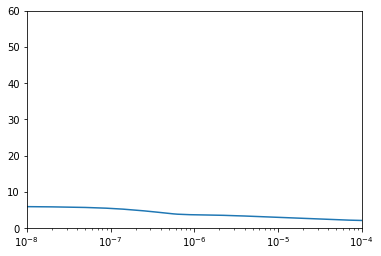

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [45]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', 
                         activation='relu', input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*25)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=300, verbose=1)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/300
25/25 [==============================] - 0s 13ms/step - loss: 5.4073 - mae: 5.8876
Epoch 2/300
25/25 [==============================] - 0s 14ms/step - loss: 2.9341 - mae: 3.4020
Epoch 3/300
25/25 [==============================] - 0s 14ms/step - loss: 2.4606 - mae: 2.9226
Epoch 4/300
25/25 [==============================] - 0s 14ms/step - loss: 2.2346 - mae: 2.6940
Epoch 5/300
25/25 [==============================] - 0s 14ms/step - loss: 2.1264 - mae: 2.5837
Epoch 6/300
25/25 [==============================] - 0s 13ms/step - loss: 2.0624 - mae: 2.5184
Epoch 7/300
25/25 [==============================] - 0s 13ms/step - loss: 2.0119 - mae: 2.4670
Epoch 8/300
25/25 [==============================] - 0s 13ms/step - loss: 1.9766 - mae: 2.4317
Epoch 9/300
25/25 [==============================] - 0s 14ms/step - loss: 1.9514 - mae: 2.4055
Epoch 10/300
25/25 [==============================] - 0s 13ms/step - loss: 1.9325 - mae: 2.3860
Epoch 11/300
25/25 [=============================

In [46]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

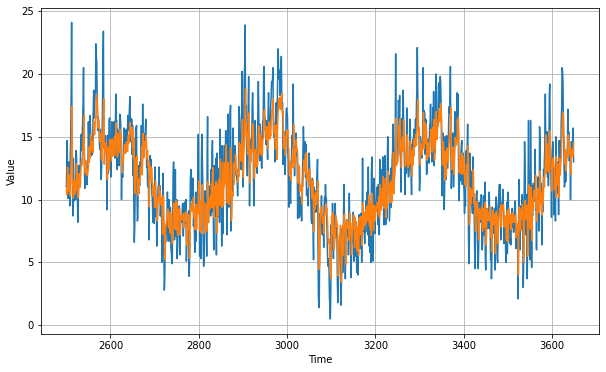

In [47]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [48]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

# My scores: 1.7854785
#            1.779156
#   1.8895043
#   1.780097

1.780097

In [49]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.78784  10.390749 11.381588 ... 13.408295 13.507697 14.555669]


In [50]:
len(rnn_forecast)

1150